In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('../data/TSLA_10years_data.csv')
scale = MinMaxScaler()
df["Close"]  = scale.fit_transform(df[["Close"]]) 
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
data = df["Close"]

C:\Users\HP\AppData\Local\Temp\ipykernel_25404\709202203.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["Date"] = pd.to_datetime(df["Date"])


In [3]:
result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.3549006838927442
p-value: 0.6036963317908852


To achieve stationarity, we can apply differencing:

In [4]:
data_diff = data.diff().dropna()
result_diff = adfuller(data_diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic: -9.197706694621804
p-value: 2.041380563863519e-15


* Identifying ARIMA Parameters

ARIMA has three parameters: (p, d, q). Here:

p: The number of lag observations included in the model (AR order).

d: The number of times that the raw observations are differenced (degree of differencing).

q: The size of the moving average window (MA order).

We can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine p and q. We’ll visualize these using:

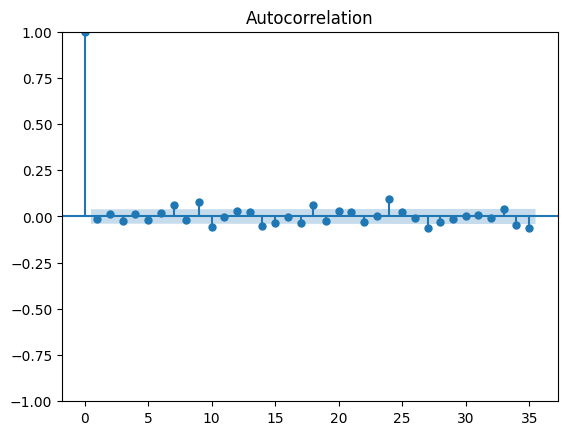

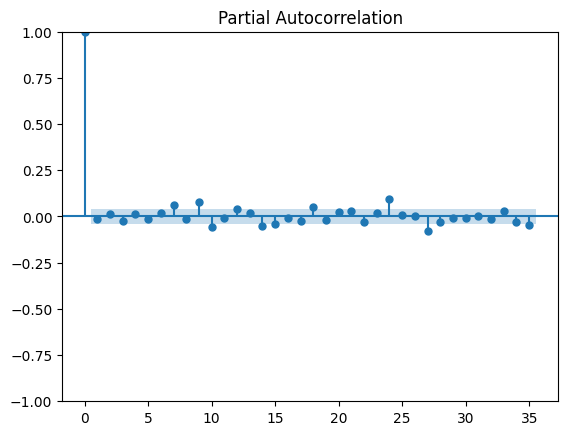

In [5]:
plot_acf(data_diff)
plt.show()
plot_pacf(data_diff)
plt.show()

ACF Plot: Shows a significant spike at lag 1, then decays slowly toward zero. This suggests the presence of an MA component, and the number of significant lags at the start (lag 1) indicates $ q = 1 $.

PACF Plot: Shows a significant spike at lag 1, then cuts off to near zero. This suggests the presence of an AR component, and the number of significant lags at the start (lag 1) indicates $ p = 1 $.

* Split Data

In [6]:
data.head()

Date
2015-08-10 00:00:00-04:00    0.013817
2015-08-11 00:00:00-04:00    0.013283
2015-08-12 00:00:00-04:00    0.013396
2015-08-13 00:00:00-04:00    0.014011
2015-08-14 00:00:00-04:00    0.014102
Name: Close, dtype: float64

In [7]:
train_data = data[data.index < pd.Timestamp('2024-01-01' ,  tz='UTC')]
test_data = data[data.index >= pd.Timestamp('2024-01-01' ,  tz='UTC')]

* Build the model

In [8]:
model = ARIMA(train_data, order=(1, 0, 1))
model_fit = model.fit()

c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


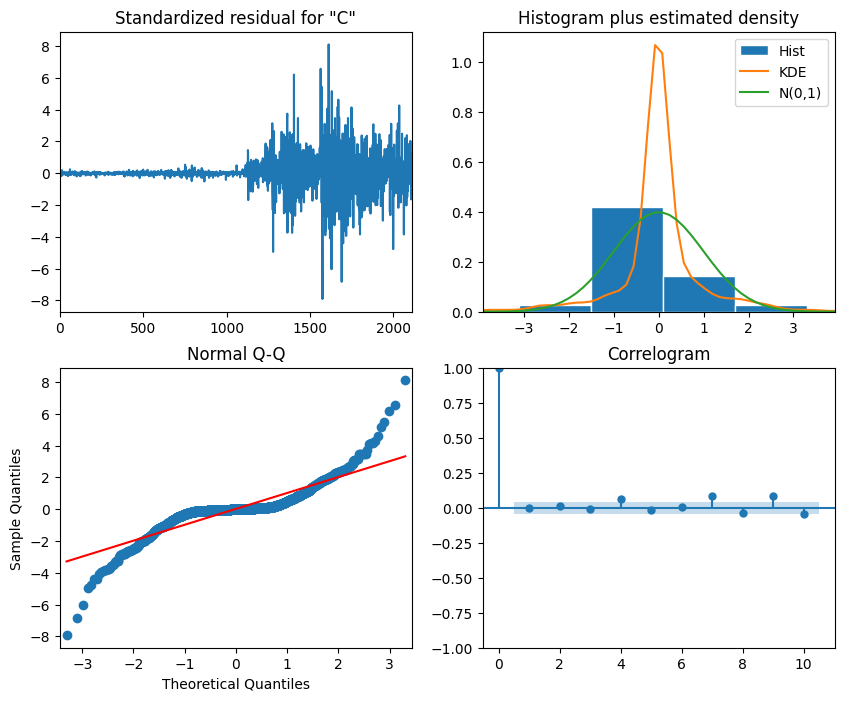

In [9]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

* Making Predictions

c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


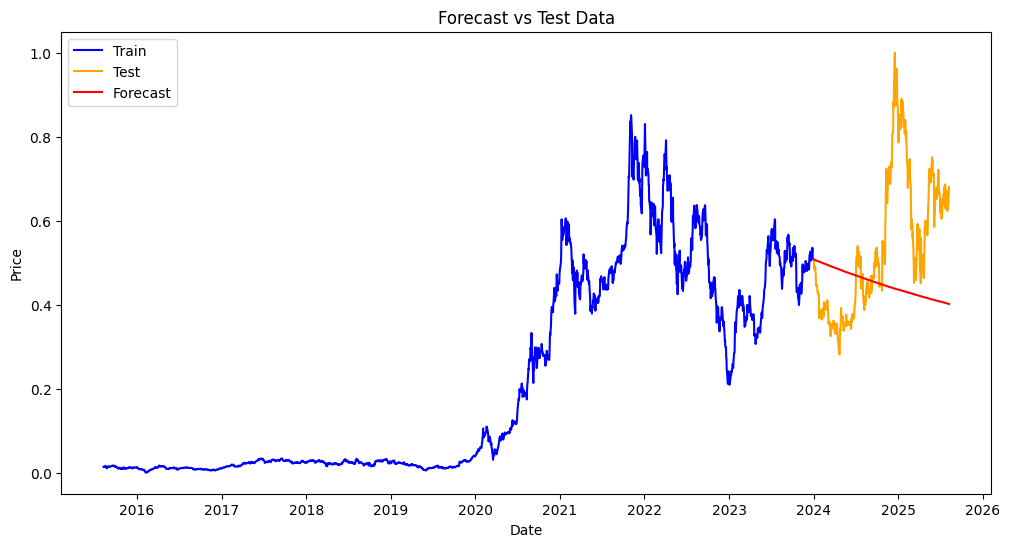

In [10]:
# Forecast
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Ensure forecast has the same index as test data
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)
forecast = pd.Series(forecast.values, index=test_data.index)


# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train', color='blue')
plt.plot(test_data, label='Test', color='orange')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


* Evaluating the Model Performance

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae_arima = mean_absolute_error(test_data, forecast)
rmse_arima = np.sqrt(mean_squared_error(test_data, forecast))
mape_arima = mean_absolute_percentage_error(test_data, forecast)

print("\nARIMA Performance:")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.2f}%")


ARIMA Performance:
MAE: 0.1640
RMSE: 0.2049
MAPE: 28.52%
